## RealNVP for the LSUN bedroom dataset

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

<table><tr>
<td> <img src="data/bedroom1.jpg" alt="bedroom 1" style="height: 210px;"/>  </td>
<td> <img src="data/bedroom2.jpg" alt="bedroom 2" style="height: 210px;"/> </td>
    <td> <img src="data/bedroom3.jpg" alt="bedroom 3" style="height: 210px;"/> </td>
</tr></table>
  
#### The LSUN Bedroom Dataset

 [LSUN dataset](https://www.yf.io/p/lsun). This is a large-scale image dataset with 10 scene and 20 object categories. A subset of the LSUN bedroom dataset has been provided, and has already been downsampled and preprocessed into smaller, fixed-size images.

* F. Yu, A. Seff, Y. Zhang, S. Song, T. Funkhouser and J. Xia. "LSUN: Construction of a Large-scale Image Dataset using Deep Learning with Humans in the Loop". [arXiv:1506.03365](https://arxiv.org/abs/1506.03365), 10 Jun 2015 



* L. Dinh, J. Sohl-Dickstein and S. Bengio. "Density estimation using Real NVP". [arXiv:1605.08803](https://arxiv.org/abs/1605.08803), 27 Feb 2017.

#### Load the dataset

loading and preprocessing the dataset. The subset consists of 10,000 training images, 1000 validation images and 1000 test images.

The images have been downsampled to 32 x 32 x 3 in order to simplify the training process.

In [1]:
# Functions for loading and preprocessing the images

def load_image(img):
    img = tf.image.random_flip_left_right(img)
    return img, img

def load_dataset(split):
    train_list_ds = tf.data.Dataset.from_tensor_slices(np.load('./data/{}.npy'.format(split)))
    train_ds = train_list_ds.map(load_image)
    return train_ds

In [3]:
# Load the training, validation and testing datasets splits

train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')

In [4]:
# Shuffle the datasets

shuffle_buffer_size = 1000
train_ds = train_ds.shuffle(shuffle_buffer_size)
val_ds = val_ds.shuffle(shuffle_buffer_size)
test_ds = test_ds.shuffle(shuffle_buffer_size)

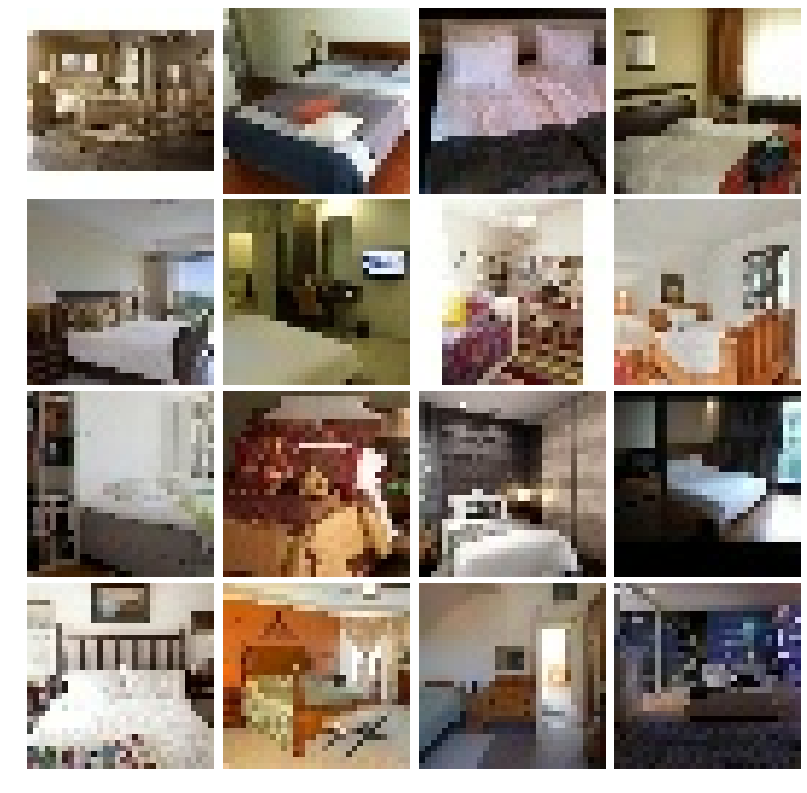

In [5]:
# Display a few examples

n_img = 4
f, axs = plt.subplots(n_img, n_img, figsize=(14, 14))

for k, image in enumerate(train_ds.take(n_img**2)):
    i = k // n_img
    j = k % n_img
    axs[i, j].imshow(image[0])
    axs[i, j].axis('off')
f.subplots_adjust(wspace=0.01, hspace=0.03)

In [6]:
# Batch the Dataset objects

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

### Affine coupling layer

begin the development of the RealNVP architecture with the core bijector that is called the _affine coupling layer_. This bijector can be described as follows: suppose that $x$ is a $D$-dimensional input, and let $d<D$. Then the output $y$ of the affine coupling layer is given by the following equations:

$$
\begin{align}
y_{1:d} &= x_{1:d} \tag{1}\\
    y_{d+1:D} &= x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d}), \tag{2}
\end{align}
$$

where $s$ and $t$ are functions from $\mathbb{R}^d\rightarrow\mathbb{R}^{D-d}$, and define the log-scale and shift operations on the vector $x_{d+1:D}$ respectively.

The log of the Jacobian determinant for this layer is given by $\sum_{j}s(x_{1:d})_j$.

The inverse operation can be easily computed as

$$
\begin{align}
x_{1:d} &= y_{1:d}\tag{3}\\
x_{d+1:D} &= \left(y_{d+1:D} - t(y_{1:d})\right)\odot \exp(-s(y_{1:d})),\tag{4}
\end{align}
$$

In practice,  implement equations $(1)$ and $(2)$ using a binary mask $b$:

$$
\begin{align}
\text{Forward pass:}\qquad y &= b\odot x + (1-b)\odot\left(x\odot\exp(s(b\odot x)) + t(b\odot x)\right),\tag{5}\\
\text{Inverse pass:}\qquad x &= b\odot y + (1-b)\odot\left(y - t(b\odot x)) \odot\exp( -s(b\odot x)\right).\tag{6}
\end{align}
$$

Our inputs $x$ will be a batch of 3-dimensional Tensors with `height`, `width` and `channels` dimensions. As in the original architecture, we will use both spatial 'checkerboard' masks and channel-wise masks:

![Checkerboard and binary masks](data/binary_masks.png)
<center>Figure 1. Spatial checkerboard mask (left) and channel-wise mask (right). From the original paper.</center>

#### Custom model for log-scale and shift



In [7]:
def get_conv_resnet(input_shape, filters):
  
    h0 = layers.Input(shape=input_shape)
    h = layers.Conv2D(filters=filters, kernel_size=(3,3), padding="SAME", kernel_regularizer=l2(5e-5), activation="relu")(h0)
    h = layers.BatchNormalization()(h)

    h = layers.Conv2D(filters=input_shape[-1], kernel_size=(3,3), padding="SAME", kernel_regularizer=l2(5e-5), activation="relu")(h)
    h = layers.BatchNormalization()(h)

    h1 = layers.Add()([h0, h])
    h = layers.Conv2D(filters=filters, kernel_size=(3,3), padding="SAME", kernel_regularizer=l2(5e-5), activation="relu")(h1)
    h = layers.BatchNormalization()(h)

    h = layers.Conv2D(filters=input_shape[-1], kernel_size=(3,3), padding="SAME", kernel_regularizer=l2(5e-5), activation="relu")(h)
    h = layers.BatchNormalization()(h)

    h = layers.Add()([h1, h])
    h2 = layers.Conv2D(filters=2*input_shape[-1], kernel_size=(3,3), padding="SAME", kernel_regularizer=l2(5e-5), activation="linear")(h)

    shift, log_scale = layers.Lambda(lambda t: tf.split(t, num_or_size_splits=2, axis=-1))(h2)

    log_scale = layers.Activation(activation="tanh")(log_scale)

    model = Model(inputs=h0, outputs=[shift, log_scale])
    return model   
    

In [8]:
# Test your function and print the model summary

conv_resnet = get_conv_resnet((32, 32, 3), 32)
conv_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 3)    867         ['batch_normalization[0][0]']

 inspect the model architecture graphically. It should look something like the following:

![ResNet plot](data/model_plot.png)

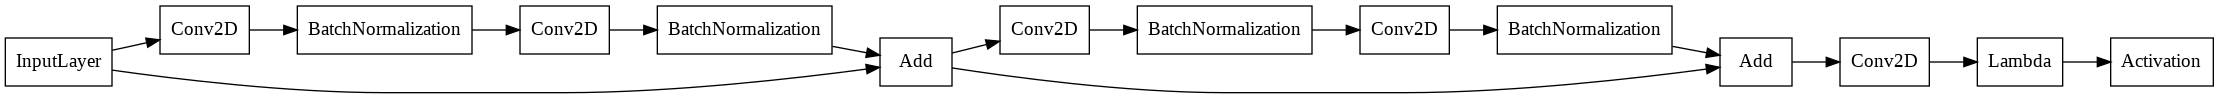

In [9]:
# Plot the model graph

tf.keras.utils.plot_model(conv_resnet, show_layer_names=False, rankdir='LR')

In [10]:
# Check the output shapes are as expected

print(conv_resnet(tf.random.normal((1, 32, 32, 3)))[0].shape)
print(conv_resnet(tf.random.normal((1, 32, 32, 3)))[1].shape)

(1, 32, 32, 3)
(1, 32, 32, 3)


#### Binary masks

Implement the affine coupling layer. 
The following function creates the spatial 'checkerboard' mask.

It takes a rank-2 `shape` as input, which correspond to the `height` and `width` dimensions, as well as an `orientation` argument (an integer equal to `0` or `1`) that determines which way round the zeros and ones are entered into the Tensor.

In [11]:
# Function to create the checkerboard mask

def checkerboard_binary_mask(shape, orientation=0):
    height, width = shape[0], shape[1]
    height_range = tf.range(height)
    width_range = tf.range(width)
    height_odd_inx = tf.cast(tf.math.mod(height_range, 2), dtype=tf.bool)
    width_odd_inx = tf.cast(tf.math.mod(width_range, 2), dtype=tf.bool)
    odd_rows = tf.tile(tf.expand_dims(height_odd_inx, -1), [1, width])
    odd_cols = tf.tile(tf.expand_dims(width_odd_inx, 0), [height, 1])
    checkerboard_mask = tf.math.logical_xor(odd_rows, odd_cols)
    if orientation == 1:
        checkerboard_mask = tf.math.logical_not(checkerboard_mask)
    return tf.cast(tf.expand_dims(checkerboard_mask, -1), tf.float32)

This function creates a rank-3 Tensor to mask the `height`, `width` and `channels` dimensions of the input. We can take a look at this checkerboard mask for some example inputs below. In order to make the Tensors easier to inspect, we will squeeze out the single channel dimension (which is always 1 for this mask).

In [12]:
# NB: we squeeze the shape for easier viewing. The full shape is (4, 4, 1)

tf.squeeze(checkerboard_binary_mask((4, 4), orientation=0))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]], dtype=float32)>

In [13]:
# The `orientation` should be 0 or 1, and determines which way round the binary entries are

tf.squeeze(checkerboard_binary_mask((4, 4), orientation=1))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.]], dtype=float32)>

the following function  create a channel-wise mask. This function takes a single integer `num_channels` as an input, as well as an `orientation` argument, similar to above. You can assume that the `num_channels` integer is even. 

The function return a rank-3 Tensor with singleton entries for `height` and `width`. In the channel axis, the first `num_channels // 2` entries  zero (for `orientation=0`) and the final `num_channels // 2` entries   one (for `orientation=0`). The zeros and ones  reversed for `orientation=1`. The `dtype` of the returned Tensor  `tf.float32`.

In [14]:

def channel_binary_mask(num_channels, orientation=0):
   
    if orientation == 0:
        return tf.concat([tf.zeros((1,1, num_channels//2), dtype=tf.float32), 
                          tf.ones((1,1, num_channels - num_channels//2), dtype=tf.float32)], axis=-1)
        
    return tf.concat([tf.ones((1,1, num_channels//2), dtype=tf.float32), 
                      tf.zeros((1,1, num_channels - num_channels//2), dtype=tf.float32)], axis=-1)    
    

In [15]:
# function to see an example channel-wise binary mask

channel_binary_mask(6, orientation=0)

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=array([[[0., 0., 0., 1., 1., 1.]]], dtype=float32)>

In [16]:

def forward(x, b, shift_and_log_scale_fn):
 
    t_shift, s_log_scale = shift_and_log_scale_fn(b*x)
    return b*x + (1-b)*(x*tf.math.exp(s_log_scale) + t_shift)
    

def inverse(y, b, shift_and_log_scale_fn):
   
    t_shift, s_log_scale = shift_and_log_scale_fn(b*y)
    return b*y + (1-b)*((y - t_shift)*tf.math.exp(-s_log_scale))
   
    

The new bijector class also requires the `log_det_jacobian` methods to be implemented. Recall that the log of the Jacobian determinant of the forward transformation is given by $\sum_{j}s(x_{1:d})_j$, where $s$ is the log-scale function of the affine coupling layer. 


In [17]:

def forward_log_det_jacobian(x, b, shift_and_log_scale_fn):

    _, s_log_scale = shift_and_log_scale_fn(b*x)
    return tf.reduce_sum((1-b)*s_log_scale, axis=[-1,-2,-3])
    
def inverse_log_det_jacobian(y, b, shift_and_log_scale_fn):

    _, s_log_scale = shift_and_log_scale_fn(b*y)
    return -tf.reduce_sum((1-b)*s_log_scale, axis=[-1,-2,-3])    
    

In [18]:
class AffineCouplingLayer(tfb.Bijector):
 
    def __init__(self, shift_and_log_scale_fn, mask_type, orientation, **kwargs):
     
        super(AffineCouplingLayer, self).__init__(forward_min_event_ndims=3, **kwargs)
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.mask_type = mask_type
        self.orientation = orientation
        
    def _get_mask(self, shape):
    
        if self.mask_type == "channel":
            return channel_binary_mask(shape[-1], self.orientation)
        return checkerboard_binary_mask(shape[1:], self.orientation)
        

    def _forward(self, x):
        b = self._get_mask(x.shape)
        return forward(x, b, self.shift_and_log_scale_fn)

    def _inverse(self, y):
        b = self._get_mask(y.shape)
        return inverse(y, b, self.shift_and_log_scale_fn)

    def _forward_log_det_jacobian(self, x):
        b = self._get_mask(x.shape)
        return forward_log_det_jacobian(x, b, self.shift_and_log_scale_fn)

    def _inverse_log_det_jacobian(self, y):
        b = self._get_mask(y.shape)
        return inverse_log_det_jacobian(y, b, self.shift_and_log_scale_fn)

In [19]:


affine_coupling_layer = AffineCouplingLayer(conv_resnet, 'channel', orientation=1, 
                                            name='affine_coupling_layer')

In [20]:
# The following should return a Tensor of the same shape as the input

affine_coupling_layer.forward(tf.random.normal((16, 32, 32, 3))).shape

TensorShape([16, 32, 32, 3])

In [21]:
# The following should compute a log_det_jacobian for each event in the batch

affine_coupling_layer.forward_log_det_jacobian(tf.random.normal((16, 32, 32, 3)), event_ndims=3).shape

TensorShape([16])

#### Combining the affine coupling layers

In the affine coupling layer, part of the input remains unchanged in the transformation $(5)$. In order to allow transformation of all of the input, several coupling layers are composed, with the orientation of the mask being reversed in subsequent layers.

<img src="data/alternating_masks.png" alt="Coupling layers" style="height: 240px;"/>
<center>Figure 2. RealNVP alternates the orientation of masks from one affine coupling layer to the next. From the original paper.</center>



In [22]:
# Bijector class for the squeezing operation

class Squeeze(tfb.Bijector):
    
    def __init__(self, name='Squeeze', **kwargs):
        super(Squeeze, self).__init__(forward_min_event_ndims=3, is_constant_jacobian=True, 
                                      name=name, **kwargs)

    def _forward(self, x):
        input_shape = x.shape
        height, width, channels = input_shape[-3:]
        y = tfb.Reshape((height // 2, 2, width // 2, 2, channels), event_shape_in=(height, width, channels))(x)
        y = tfb.Transpose(perm=[0, 2, 1, 3, 4])(y)
        y = tfb.Reshape((height // 2, width // 2, 4 * channels),
                        event_shape_in=(height // 2, width // 2, 2, 2, channels))(y)
        return y

    def _inverse(self, y):
        input_shape = y.shape
        height, width, channels = input_shape[-3:]
        x = tfb.Reshape((height, width, 2, 2, channels // 4), event_shape_in=(height, width, channels))(y)
        x = tfb.Transpose(perm=[0, 2, 1, 3, 4])(x)
        x = tfb.Reshape((2 * height, 2 * width, channels // 4),
                        event_shape_in=(height, 2, width, 2, channels // 4))(x)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)

    def _inverse_log_det_jacobian(self, y):
        return tf.constant(0., y.dtype)

    def _forward_event_shape_tensor(self, input_shape):
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        return height // 2, width // 2, 4 * channels

    def _inverse_event_shape_tensor(self, output_shape):
        height, width, channels = output_shape[-3], output_shape[-2], output_shape[-1]
        return height * 2, width * 2, channels // 4

In [23]:
# Test the Squeeze bijector

squeeze = Squeeze()
squeeze(tf.ones((10, 32, 32, 3))).shape

TensorShape([10, 16, 16, 12])

In [24]:
# Test the inverse operation

squeeze.inverse(tf.ones((10, 4, 4, 96))).shape

TensorShape([10, 8, 8, 24])

now construct a block of coupling layers according to the architecture 


In [25]:

def realnvp_block(shift_and_log_scale_fns, squeeze):
   
    block = [AffineCouplingLayer(shift_and_log_scale_fns[0], 'checkerboard', orientation=0),
             AffineCouplingLayer(shift_and_log_scale_fns[1], 'checkerboard', orientation=1),
             AffineCouplingLayer(shift_and_log_scale_fns[2], 'checkerboard', orientation=0),
             tfb.BatchNormalization(),
             squeeze,
             AffineCouplingLayer(shift_and_log_scale_fns[3], 'channel', orientation=0),
             AffineCouplingLayer(shift_and_log_scale_fns[4], 'channel', orientation=1),
             AffineCouplingLayer(shift_and_log_scale_fns[5], 'channel', orientation=0),
             tfb.BatchNormalization()
            ]
    
    return tfb.Chain(list(reversed(block)))   
    

In [26]:
#Run function to create an instance of the bijector

checkerboard_fns = []
for _ in range(3):
    checkerboard_fns.append(get_conv_resnet((32, 32, 3), 512))
channel_fns = []
for _ in range(3):
    channel_fns.append(get_conv_resnet((16, 16, 12), 512))
    
block = realnvp_block(checkerboard_fns + channel_fns, squeeze)

In [27]:
# Test the bijector on a dummy input

block.forward(tf.random.normal((10, 32, 32, 3))).shape

TensorShape([10, 16, 16, 12])

#### Multiscale architecture

The final component of the RealNVP is the multiscale architecture. The squeeze operation reduces the spatial dimensions but increases the channel dimensions. After one of the blocks of coupling-squeeze-coupling that you have implemented above, half of the dimensions are factored out as latent variables, while the other half is further processed through subsequent layers. This results in latent variables that represent different scales of features in the model.

<img src="data/multiscale.png" alt="Multiscale architecture" style="height: 320px;"/>
<center>Figure 3. RealNVP creates latent variables at different scales by factoring out half of the dimensions at each scale. From the original paper.</center>

The final scale does not use the squeezing operation, and instead applies four affine coupling layers with alternating checkerboard masks.

The multiscale architecture for two latent variable scales is implemented for you in the following bijector.

In [28]:
# Bijector to implement the multiscale architecture

class RealNVPMultiScale(tfb.Bijector):
    
    def __init__(self, **kwargs):
        super(RealNVPMultiScale, self).__init__(forward_min_event_ndims=3, **kwargs)

        # First level
        shape1 = (32, 32, 3)  # Input shape
        shape2 = (16, 16, 12)  # Shape after the squeeze operation
        shape3 = (16, 16, 6)  # Shape after factoring out the latent variable
        self.conv_resnet1 = get_conv_resnet(shape1, 64)
        self.conv_resnet2 = get_conv_resnet(shape1, 64)
        self.conv_resnet3 = get_conv_resnet(shape1, 64)
        self.conv_resnet4 = get_conv_resnet(shape2, 128)
        self.conv_resnet5 = get_conv_resnet(shape2, 128)
        self.conv_resnet6 = get_conv_resnet(shape2, 128)
        self.squeeze = Squeeze()
        self.block1 = realnvp_block([self.conv_resnet1, self.conv_resnet2,
                                    self.conv_resnet3, self.conv_resnet4,
                                    self.conv_resnet5, self.conv_resnet6], self.squeeze)

        # Second level
        self.conv_resnet7 = get_conv_resnet(shape3, 128)
        self.conv_resnet8 = get_conv_resnet(shape3, 128)
        self.conv_resnet9 = get_conv_resnet(shape3, 128)
        self.conv_resnet10 = get_conv_resnet(shape3, 128)
        self.coupling_layer1 = AffineCouplingLayer(self.conv_resnet7, 'checkerboard', 0)
        self.coupling_layer2 = AffineCouplingLayer(self.conv_resnet8, 'checkerboard', 1)
        self.coupling_layer3 = AffineCouplingLayer(self.conv_resnet9, 'checkerboard', 0)
        self.coupling_layer4 = AffineCouplingLayer(self.conv_resnet10, 'checkerboard', 1)
        self.block2 = tfb.Chain([self.coupling_layer4, self.coupling_layer3,
                                 self.coupling_layer2, self.coupling_layer1])

    def _forward(self, x):
        h1 = self.block1.forward(x)
        z1, h2 = tf.split(h1, 2, axis=-1)
        z2 = self.block2.forward(h2)
        return tf.concat([z1, z2], axis=-1)
        
    def _inverse(self, y):
        z1, z2 = tf.split(y, 2, axis=-1)
        h2 = self.block2.inverse(z2)
        h1 = tf.concat([z1, h2], axis=-1)
        return self.block1.inverse(h1)

    def _forward_log_det_jacobian(self, x):
        log_det1 = self.block1.forward_log_det_jacobian(x, event_ndims=3)
        h1 = self.block1.forward(x)
        _, h2 = tf.split(h1, 2, axis=-1)
        log_det2 = self.block2.forward_log_det_jacobian(h2, event_ndims=3)
        return log_det1 + log_det2

    def _inverse_log_det_jacobian(self, y):
        z1, z2 = tf.split(y, 2, axis=-1)
        h2 = self.block2.inverse(z2)
        log_det2 = self.block2.inverse_log_det_jacobian(z2, event_ndims=3)
        h1 = tf.concat([z1, h2], axis=-1)
        log_det1 = self.block1.inverse_log_det_jacobian(h1, event_ndims=3)
        return log_det1 + log_det2

    def _forward_event_shape_tensor(self, input_shape):
        height, width, channels = input_shape[-3], input_shape[-2], input_shape[-1]
        return height // 4, width // 4, 16 * channels

    def _inverse_event_shape_tensor(self, output_shape):
        height, width, channels = output_shape[-3], output_shape[-2], output_shape[-1]
        return 4 * height, 4 * width, channels // 16

In [29]:
# Create an instance of the multiscale architecture

multiscale_bijector = RealNVPMultiScale()

#### Data preprocessing bijector

We will also preprocess the image data before sending it through the RealNVP model. To do this, for a Tensor $x$ of pixel values in $[0, 1]^D$, we transform $x$ according to the following:

$$
T(x) = \text{logit}\left(\alpha + (1 - 2\alpha)x\right),\tag{7}
$$

where $\alpha$ is a parameter, and the logit function is the inverse of the sigmoid function, and is given by 

$$
\text{logit}(p) = \log (p) - \log (1 - p).
$$




In [30]:


def get_preprocess_bijector(alpha):
   
    return  tfb.Chain([tfb.Invert(tfb.Sigmoid()), 
                       tfb.Shift(alpha), 
                       tfb.Scale(1 - 2*alpha)])    
    

In [31]:
# Create an instance of the preprocess bijector

preprocess = get_preprocess_bijector(0.05)

#### Train the RealNVP model

Finally,  use  RealNVP model to train

We will use the following model class to help with the training process.

In [32]:
# Helper class for training

class RealNVPModel(Model):

    def __init__(self, **kwargs):
        super(RealNVPModel, self).__init__(**kwargs)
        self.preprocess = get_preprocess_bijector(0.05)
        self.realnvp_multiscale = RealNVPMultiScale()
        self.bijector = tfb.Chain([self.realnvp_multiscale, self.preprocess])
        
    def build(self, input_shape):
        output_shape = self.bijector(tf.expand_dims(tf.zeros(input_shape[1:]), axis=0)).shape
        self.base = tfd.Independent(tfd.Normal(loc=tf.zeros(output_shape[1:]), scale=1.),
                                    reinterpreted_batch_ndims=3)
        self._bijector_variables = (
            list(self.bijector.variables))
        self.flow = tfd.TransformedDistribution(
            distribution=self.base,
            bijector=tfb.Invert(self.bijector),
        )
        super(RealNVPModel, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        return self.flow

    def sample(self, batch_size):
        sample = self.base.sample(batch_size)
        return self.bijector.inverse(sample)


In [33]:
# Create an instance of the RealNVPModel class

realnvp_model = RealNVPModel()
realnvp_model.build((1, 32, 32, 3))

In [34]:
# Compute the number of variables in the model

print("Total trainable variables:")
print(sum([np.prod(v.shape) for v in realnvp_model.trainable_variables]))

Total trainable variables:
315180


Note that the model's `call` method returns the `TransformedDistribution` object. Also, we have set up our datasets to return the input image twice as a 2-tuple. This is so we can train our model with negative log-likelihood as normal.

In [35]:
# Define the negative log-likelihood loss function

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

It is recommended to use the GPU accelerator hardware on Colab to train this model, as it can take some time to train. Note that it is not required to train the model in order to pass this assignment. For optimal results, a larger model should be trained for longer.

In [ ]:
# Compile and train the model

optimizer = Adam()
realnvp_model.compile(loss=nll, optimizer=Adam())
realnvp_model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30


In [ ]:
# Evaluate the model

realnvp_model.evaluate(test_ds)

#### Generate some samples

In [ ]:
# Sample from the model

samples = realnvp_model.sample(8).numpy()

In [ ]:
# Display the samples

n_img = 8
f, axs = plt.subplots(2, n_img // 2, figsize=(14, 7))

for k, image in enumerate(samples):
    i = k % 2
    j = k // 2
    axs[i, j].imshow(np.clip(image, 0., 1.))
    axs[i, j].axis('off')
f.subplots_adjust(wspace=0.01, hspace=0.03)